This file contains the initial testing of prompts and chunk size testing, the file called Lab2_Part3_Team17_part2 contains the final rouge score and optimal prompts.

##Imports

In [ ]:
# Install necessary libraries
!pip install langchain langchain-openai langchain-core langchain-community
!pip install faiss-cpu
!pip install PyPDF2
!pip install openai
!pip install rouge-score
!pip install python-dotenv

In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5


In [ ]:
!pip install httpx==0.27.2 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: sniffio
    Found existing installation: sniffio 1.3.1
    Uninstalling sniffio-1.3.1:
      Successfully uninstalled sniffio-1.3.1
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: h11
    F

In [ ]:
# Import libraries
import os
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from rouge_score import rouge_scorer
import json
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.chains.question_answering import load_qa_chain

##Code

In [ ]:
# Load environment variables from .env file
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("API key not found. Ensure the .env file is correctly set up.")

os.environ["OPENAI_API_KEY"] = api_key

In [ ]:
# Define function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    reader = PdfReader(pdf_path)
    all_text = ""
    for page in reader.pages:
        all_text += page.extract_text() + "\n"
    return all_text

# Define function to split text into chunks using LangChain Text Splitter
def split_text_into_chunks(text, chunk_size=1000, chunk_overlap=100):
    """Split text into smaller chunks using LangChain RecursiveCharacterTextSplitter."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", " ", ""]
    )
    chunks = splitter.split_text(text)
    return chunks

# Define function to create FAISS index
def create_faiss_index(text_chunks, embedding_model):
    """Create a FAISS index for document retrieval."""
    index = FAISS.from_texts(text_chunks, embedding_model)
    return index

# Load PDF and create text chunks
pdf_path = "/content/Part3_knowledge base.pdf"
raw_text = extract_text_from_pdf(pdf_path)
text_chunks = split_text_into_chunks(raw_text)

# Initialize embedding model and FAISS index
embedding_model = OpenAIEmbeddings()
faiss_index = create_faiss_index(text_chunks, embedding_model)

# Initialize retriever and chat model
retriever = faiss_index.as_retriever()
chat_model = ChatOpenAI(model="gpt-4o", temperature=0)

<ipython-input-6-48621420c2c3>:33: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_model = OpenAIEmbeddings()
<ipython-input-6-48621420c2c3>:38: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chat_model = ChatOpenAI(model="gpt-4o", temperature=0)


In [ ]:
ground_truth = [
    {
        "question": "How did Meta’s workforce change by the end of 2023?",
        "answer": "By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022."
    },
    {
        "question": "What is the report quarter, and when did it end?",
        "answer": "The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023."
    },
    {
        "question": "What were the key financial highlights this quarter (revenue, gross margin, operating expenses, operating margin, net income, and EPS)?",
        "answer": "Key financial highlights for Q4 2023 include: Revenue - $40.11 billion, Operating expenses - $23.73 billion, Operating margin - 41%, Net income - $14.02 billion, and EPS - $5.33 (diluted)."
    },
    {
        "question": "How much did Meta spend on restructuring for the whole year and Q4?",
        "answer": "Meta spent $1.15 billion on restructuring in Q4 2023 and $3.45 billion for the entire year of 2023."
    },
    {
        "question": "What happened with Meta’s ad impressions and average price per ad in Q4 and for the whole year?",
        "answer": "In Q4 2023, ad impressions increased by 21% year-over-year, and the average price per ad increased by 2%. For the whole year 2023, ad impressions increased by 28%, while the average price per ad decreased by 9%."
    },
    {
        "question": "What’s the revenue outlook for Q1 2024?",
        "answer": "Meta expects Q1 2024 revenue to be in the range of $34.5 billion to $37 billion."
    },
    {
        "question": "What were Meta’s total costs and expenses for Q4 and the full year 2023?",
        "answer": "Meta's total costs and expenses were $23.73 billion for Q4 2023 and $88.15 billion for the full year 2023."
    },
    {
        "question": "How much cash and marketable securities did Meta have on hand as of December 31, 2023?",
        "answer": "Meta had $65.40 billion in cash, cash equivalents, and marketable securities as of December 31, 2023."
    },
    {
        "question": "What were the main areas Meta invested in during 2023?",
        "answer": "Meta invested significantly in infrastructure, including data centers and AI hardware, as well as in Reality Labs for AR/VR product development."
    },
    {
        "question": "How did the Family of Apps and Reality Labs perform in Q4 2023?",
        "answer": "In Q4 2023, Family of Apps revenue was $39.04 billion with operating income of $21.03 billion. Reality Labs revenue was $1.07 billion with an operating loss of $4.65 billion."
    },
    {
        "question": "How much free cash flow did Meta generate in Q4 and the full year 2023?",
        "answer": "Meta generated $11.50 billion in free cash flow for Q4 2023 and $43.01 billion for the full year 2023."
    },
    {
        "question": "Did Meta make any changes to its stock repurchase program or dividends for 2024?",
        "answer": "Meta announced a $50 billion increase in its stock repurchase authorization and initiated a quarterly dividend of $0.50 per share, payable on March 26, 2024."
    },
    {
        "question": "What risks did Meta highlight for 2024?",
        "answer": "Meta highlighted risks including increased regulatory headwinds in the EU and US, changes in data policies, and escalating infrastructure and payroll costs due to ongoing investments."
    },
    {
        "question": "What drove Meta’s revenue growth in Q4 2023?",
        "answer": "Revenue growth in Q4 2023 was driven by a 21% increase in ad impressions and a 2% increase in the average price per ad."
    },
    {
        "question": "How did Reality Labs perform throughout 2023, and what’s Meta’s plan for 2024?",
        "answer": "Reality Labs generated $1.90 billion in revenue in 2023 but incurred a loss of $16.12 billion. For 2024, Meta plans to continue investing in AR/VR product development and scaling its ecosystem, expecting increased operating losses."
    }
]

In [ ]:
# Initialize storage for evaluation results
evaluation_results_summary = []
evaluation_results_detailed = {}

# Function to evaluate the RAG system with a custom prompt, compute averages, and save/display results
def evaluate_rag_with_prompt(chat_model, retriever, ground_truth, prompt_template, prompt_name):
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Define a PromptTemplate with the provided template
    prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

    # Load the QA chain
    qa_chain = load_qa_chain(
        llm=chat_model,
        chain_type="stuff",
        prompt=prompt
    )

    # Define the RetrievalQAWithSourcesChain
    retrieval_chain = RetrievalQAWithSourcesChain(
        retriever=retriever,
        combine_documents_chain=qa_chain
    )

    results = []

    for pair in ground_truth:
        # Run the retrieval chain with the question
        response = retrieval_chain({"question": pair["question"]})

        # Extract the predicted answer from the response
        predicted_answer = response.get("answer", "I don't know")

        # Compute ROUGE scores
        scores = scorer.score(pair["answer"], predicted_answer)
        results.append({
            "question": pair["question"],
            "ground_truth": pair["answer"],
            "predicted_answer": predicted_answer,
            "rouge1": scores['rouge1'].fmeasure,
            "rouge2": scores['rouge2'].fmeasure,
            "rougeL": scores['rougeL'].fmeasure,
        })

    # Compute average ROUGE scores
    def compute_average_rouge(evaluation_results):
        """Compute the average ROUGE-1, ROUGE-2, and ROUGE-L scores."""
        rouge1_total = 0
        rouge2_total = 0
        rougeL_total = 0
        count = len(evaluation_results)

        for result in evaluation_results:
            rouge1_total += result["rouge1"]
            rouge2_total += result["rouge2"]
            rougeL_total += result["rougeL"]

        avg_rouge1 = rouge1_total / count
        avg_rouge2 = rouge2_total / count
        avg_rougeL = rougeL_total / count

        return {"avg_rouge1": avg_rouge1, "avg_rouge2": avg_rouge2, "avg_rougeL": avg_rougeL}

    # Compute averages
    average_scores = compute_average_rouge(results)

    # Append results to the global storage variables
    global evaluation_results_summary, evaluation_results_detailed
    evaluation_results_summary.append({
        "Prompt Name": prompt_name,  # Use the provided prompt_name for labeling
        "Average ROUGE-1": average_scores["avg_rouge1"],
        "Average ROUGE-2": average_scores["avg_rouge2"],
        "Average ROUGE-L": average_scores["avg_rougeL"],
    })

    evaluation_results_detailed[prompt_name] = {
        "ROUGE-1": [res["rouge1"] for res in results],
        "ROUGE-2": [res["rouge2"] for res in results],
        "ROUGE-L": [res["rougeL"] for res in results],
    }

    # Display individual results
    print("Individual Results:")
    for result in results:
        print(f"Question: {result['question']}")
        print(f"Ground Truth: {result['ground_truth']}")
        print(f"Predicted Answer: {result['predicted_answer']}")
        print(f"ROUGE-1: {result['rouge1']}, ROUGE-2: {result['rouge2']}, ROUGE-L: {result['rougeL']}\n")

    # Display average ROUGE scores
    print("Average ROUGE Scores:")
    print(f"ROUGE-1: {average_scores['avg_rouge1']:.4f}")
    print(f"ROUGE-2: {average_scores['avg_rouge2']:.4f}")
    print(f"ROUGE-L: {average_scores['avg_rougeL']:.4f}")

    return {"results": results, "average_scores": average_scores}

##Prompt Testing

###prompt1

In [ ]:
# Define your prompt
prompt1 = """
Use the context below to answer the question. If the answer cannot be found in the context, say "I don't know."

Context: {context}
Question: {question}
Answer:
"""

# Evaluate
evaluation_output = evaluate_rag_with_prompt(
    chat_model=chat_model,
    retriever=retriever,
    ground_truth=ground_truth,
    prompt_template=prompt1,
    prompt_name="Prompt 1"
)

<ipython-input-9-6f89d226fd8f>:14: LangChainDeprecationWarning: This class is deprecated. See the following migration guides for replacements based on `chain_type`:
stuff: https://python.langchain.com/docs/versions/migrating_chains/stuff_docs_chain
map_reduce: https://python.langchain.com/docs/versions/migrating_chains/map_reduce_chain
refine: https://python.langchain.com/docs/versions/migrating_chains/refine_chain
map_rerank: https://python.langchain.com/docs/versions/migrating_chains/map_rerank_docs_chain

See also guides on retrieval and question-answering here: https://python.langchain.com/docs/how_to/#qa-with-rag
  qa_chain = load_qa_chain(
<ipython-input-9-6f89d226fd8f>:30: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = retrieval_chain({"question": pair["question"]})


Individual Results:
Question: How did Meta’s workforce change by the end of 2023?
Ground Truth: By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022.
Predicted Answer: I don't know.
ROUGE-1: 0.0, ROUGE-2: 0.0, ROUGE-L: 0.0

Question: What is the report quarter, and when did it end?
Ground Truth: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.
Predicted Answer: The report quarter is the fourth quarter, and it ended on December 31, 2023.
ROUGE-1: 0.7999999999999999, ROUGE-2: 0.7142857142857142, ROUGE-L: 0.7999999999999999

Question: What were the key financial highlights this quarter (revenue, gross margin, operating expenses, operating margin, net income, and EPS)?
Ground Truth: Key financial highlights for Q4 2023 include: Revenue - $40.11 billion, Operating expenses - $23.73 billion, Operating margin - 41%, Net income - $14.02 billion, and EPS - $5.33 (dilute

###prompt2

In [ ]:
# Define your prompt
prompt2 = """
You are a data analyst assisting with financial reports. Use the context below to answer the question with specific and concise details.
If the answer cannot be found in the context, respond with "I don't know."

Context:
{context}

Question:
{question}

Answer:
"""
# Evaluate
evaluation_output = evaluate_rag_with_prompt(
    chat_model=chat_model,
    retriever=retriever,
    ground_truth=ground_truth,
    prompt_template=prompt2,
    prompt_name="Prompt 2"
)

Individual Results:
Question: How did Meta’s workforce change by the end of 2023?
Ground Truth: By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022.
Predicted Answer: I don't know.
ROUGE-1: 0.0, ROUGE-2: 0.0, ROUGE-L: 0.0

Question: What is the report quarter, and when did it end?
Ground Truth: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.
Predicted Answer: The report quarter is the fourth quarter, and it ended on December 31, 2023.
ROUGE-1: 0.7999999999999999, ROUGE-2: 0.7142857142857142, ROUGE-L: 0.7999999999999999

Question: What were the key financial highlights this quarter (revenue, gross margin, operating expenses, operating margin, net income, and EPS)?
Ground Truth: Key financial highlights for Q4 2023 include: Revenue - $40.11 billion, Operating expenses - $23.73 billion, Operating margin - 41%, Net income - $14.02 billion, and EPS - $5.33 (dilute

###prompt3

In [ ]:
prompt3 = """
You are a financial analysis assistant. Use the context below to answer the question accurately and concisely, focusing on specific data points and numerical details where applicable.

If the answer cannot be found in the context, respond with "I don't know." Avoid making assumptions or including information not present in the context.

Context:
{context}

Question:
{question}

Answer:
"""

# Evaluate
evaluation_output = evaluate_rag_with_prompt(
    chat_model=chat_model,
    retriever=retriever,
    ground_truth=ground_truth,
    prompt_template=prompt3,
    prompt_name="Prompt 3"
)

Individual Results:
Question: How did Meta’s workforce change by the end of 2023?
Ground Truth: By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022.
Predicted Answer: I don't know.
ROUGE-1: 0.0, ROUGE-2: 0.0, ROUGE-L: 0.0

Question: What is the report quarter, and when did it end?
Ground Truth: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.
Predicted Answer: The report quarter is the fourth quarter, and it ended on December 31, 2023.
ROUGE-1: 0.7999999999999999, ROUGE-2: 0.7142857142857142, ROUGE-L: 0.7999999999999999

Question: What were the key financial highlights this quarter (revenue, gross margin, operating expenses, operating margin, net income, and EPS)?
Ground Truth: Key financial highlights for Q4 2023 include: Revenue - $40.11 billion, Operating expenses - $23.73 billion, Operating margin - 41%, Net income - $14.02 billion, and EPS - $5.33 (dilute

###prompt4

In [ ]:
prompt4 = """
You are a financial data analyst tasked with providing precise, accurate, and concise answers using the context provided below.

- Include numerical details wherever possible, especially for increases, decreases, percentages, and calculations derived from the information provided.
- If the exact information is not present, use available data to calculate or infer the answer to the best of your ability.
- If no relevant data is available, respond with "I don't know."
- Focus on specific data points, dates, and numerical values.

Context:
{context}

Question:
{question}

Answer:
"""

# Evaluate
evaluation_output = evaluate_rag_with_prompt(
    chat_model=chat_model,
    retriever=retriever,
    ground_truth=ground_truth,
    prompt_template=prompt4,
    prompt_name="Prompt 4"
)

Individual Results:
Question: How did Meta’s workforce change by the end of 2023?
Ground Truth: By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022.
Predicted Answer: I don't know.
ROUGE-1: 0.0, ROUGE-2: 0.0, ROUGE-L: 0.0

Question: What is the report quarter, and when did it end?
Ground Truth: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.
Predicted Answer: The report quarter is the fourth quarter, and it ended on December 31, 2023.
ROUGE-1: 0.7999999999999999, ROUGE-2: 0.7142857142857142, ROUGE-L: 0.7999999999999999

Question: What were the key financial highlights this quarter (revenue, gross margin, operating expenses, operating margin, net income, and EPS)?
Ground Truth: Key financial highlights for Q4 2023 include: Revenue - $40.11 billion, Operating expenses - $23.73 billion, Operating margin - 41%, Net income - $14.02 billion, and EPS - $5.33 (dilute

###prompt5

In [ ]:
prompt5 = """
You are a financial data analyst assisting with financial reports. Use the context provided below to answer the question accurately, concisely, and in detail.

- Include specific numerical details wherever possible, especially for increases, decreases, percentages, and calculated values derived from the context.
- Format your answers to directly address the question in the simplest terms, matching the style and structure of the examples provided.
- Avoid over-explaining or including irrelevant information.
- If the context does not contain the required information, respond with "I don't know."

Context:
{context}

Question:
{question}

Answer:
"""

# Evaluate
evaluation_output = evaluate_rag_with_prompt(
    chat_model=chat_model,
    retriever=retriever,
    ground_truth=ground_truth,
    prompt_template=prompt5,
    prompt_name="Prompt 5"
)


Individual Results:
Question: How did Meta’s workforce change by the end of 2023?
Ground Truth: By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022.
Predicted Answer: I don't know.
ROUGE-1: 0.0, ROUGE-2: 0.0, ROUGE-L: 0.0

Question: What is the report quarter, and when did it end?
Ground Truth: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.
Predicted Answer: The report quarter is the fourth quarter, and it ended on December 31, 2023.
ROUGE-1: 0.7999999999999999, ROUGE-2: 0.7142857142857142, ROUGE-L: 0.7999999999999999

Question: What were the key financial highlights this quarter (revenue, gross margin, operating expenses, operating margin, net income, and EPS)?
Ground Truth: Key financial highlights for Q4 2023 include: Revenue - $40.11 billion, Operating expenses - $23.73 billion, Operating margin - 41%, Net income - $14.02 billion, and EPS - $5.33 (dilute

###prompt6

In [ ]:

prompt6 = """
You are a financial data analyst tasked with answering questions about financial reports.

- Use only the information provided in the context to answer the question accurately and concisely.
- Include specific numerical details wherever applicable (e.g., percentages, increases, or decreases) and perform calculations based on the context.
- Avoid including extra points, tangential information, or assumptions that are not directly relevant to the question.
- Ensure the answer is formatted in a direct, single-paragraph response.
- If the context does not contain the required information, respond with "I don't know."

Context:
{context}

Question:
{question}

Answer:
"""

# Evaluate
evaluation_output = evaluate_rag_with_prompt(
    chat_model=chat_model,
    retriever=retriever,
    ground_truth=ground_truth,
    prompt_template=prompt6,
    prompt_name="Prompt 6"
)


Individual Results:
Question: How did Meta’s workforce change by the end of 2023?
Ground Truth: By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022.
Predicted Answer: I don't know.
ROUGE-1: 0.0, ROUGE-2: 0.0, ROUGE-L: 0.0

Question: What is the report quarter, and when did it end?
Ground Truth: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.
Predicted Answer: The report quarter is the fourth quarter, and it ended on December 31, 2023.
ROUGE-1: 0.7999999999999999, ROUGE-2: 0.7142857142857142, ROUGE-L: 0.7999999999999999

Question: What were the key financial highlights this quarter (revenue, gross margin, operating expenses, operating margin, net income, and EPS)?
Ground Truth: Key financial highlights for Q4 2023 include: Revenue - $40.11 billion, Operating expenses - $23.73 billion, Operating margin - 41%, Net income - $14.02 billion, and EPS - $5.33 (dilute

###prompt7

In [ ]:
prompt7 = """
You are a financial data analyst tasked with answering questions about financial reports.

- Use only the information provided in the context to answer the question accurately and concisely.
- Include specific numerical details wherever applicable (e.g., percentages, increases, or decreases) and perform calculations based on the context.
- Don't return special characters
- Avoid including extra points, tangential information, or assumptions that are not directly relevant to the question.
- Ensure the answer is formatted in a direct, single-paragraph response.
- If the context does not contain the required information, respond with "I don't know."

### Example Questions and Answers:
1. **Question**: How did Meta’s workforce change by the end of 2023?
   **Workforce Change Calculation**:
   - Step 1: Identify the old and new values. Old Value = 87,314 (2022 workforce), New Value = 67,317 (2023 workforce).
   - Step 2: Subtract the new value from the old value to find the difference: \( 87,314 - 67,317 = 19,997 \).
   - Step 3: Divide the difference by the old value to calculate the percentage change:
     \( \frac{{19,997}}{{87,314}} \approx 0.229 \).
   - Step 4: Multiply by 100 to convert to a percentage:
     \( 0.229 \times 100 = 22.9\% \).

   **Answer**: By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022.

2. **Question**: What is the report quarter, and when did it end?
   **Answer**: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.

### Your Task:
Context:
{context}

Question:
{question}

Answer:
"""

# Evaluate
evaluation_output = evaluate_rag_with_prompt(
    chat_model=chat_model,
    retriever=retriever,
    ground_truth=ground_truth,
    prompt_template=prompt7,
    prompt_name="Prompt 7"
)


Individual Results:
Question: How did Meta’s workforce change by the end of 2023?
Ground Truth: By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022.
Predicted Answer: I don't know.
ROUGE-1: 0.0, ROUGE-2: 0.0, ROUGE-L: 0.0

Question: What is the report quarter, and when did it end?
Ground Truth: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.
Predicted Answer: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.
ROUGE-1: 1.0, ROUGE-2: 1.0, ROUGE-L: 1.0

Question: What were the key financial highlights this quarter (revenue, gross margin, operating expenses, operating margin, net income, and EPS)?
Ground Truth: Key financial highlights for Q4 2023 include: Revenue - $40.11 billion, Operating expenses - $23.73 billion, Operating margin - 41%, Net income - $14.02 billion, and EPS - $5.33 (diluted).
Predicted Answer: For the 

###prompt8

In [ ]:
prompt8 = """
You are a financial analyst tasked with answering questions based on the provided context. Follow these rules:
1. Use the information in the context to provide specific and concise answers.
2. Perform calculations if the question requires them.
3. Don't return special characters
4. If the answer cannot be determined from the context, respond with "I don't know."

### Example Question and Answer
**Question**: How did Meta’s workforce change by the end of 2023?
**Context**: Workforce in 2022: 87,314, Workforce in 2023: 67,317.
**Calculation**: (Old Value − New Value) / Old Value × 100% = (87,314 − 67,317) / 87,314 × 100% ≈ 22.9%.
**Answer**: By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022.

**Question**: What is the report quarter, and when did it end?
**Context**: The report covers the fourth quarter of 2023, ending December 31, 2023.
**Answer**: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.

### Your Task
Context:
{context}

Question:
{question}

Answer:
"""

# Evaluate
evaluation_output = evaluate_rag_with_prompt(
    chat_model=chat_model,
    retriever=retriever,
    ground_truth=ground_truth,
    prompt_template=prompt8,
    prompt_name="Prompt 8"
)

Individual Results:
Question: How did Meta’s workforce change by the end of 2023?
Ground Truth: By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022.
Predicted Answer: I don't know.
ROUGE-1: 0.0, ROUGE-2: 0.0, ROUGE-L: 0.0

Question: What is the report quarter, and when did it end?
Ground Truth: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.
Predicted Answer: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.
ROUGE-1: 1.0, ROUGE-2: 1.0, ROUGE-L: 1.0

Question: What were the key financial highlights this quarter (revenue, gross margin, operating expenses, operating margin, net income, and EPS)?
Ground Truth: Key financial highlights for Q4 2023 include: Revenue - $40.11 billion, Operating expenses - $23.73 billion, Operating margin - 41%, Net income - $14.02 billion, and EPS - $5.33 (diluted).
Predicted Answer: Key fina

###prompt score comparison visualizations

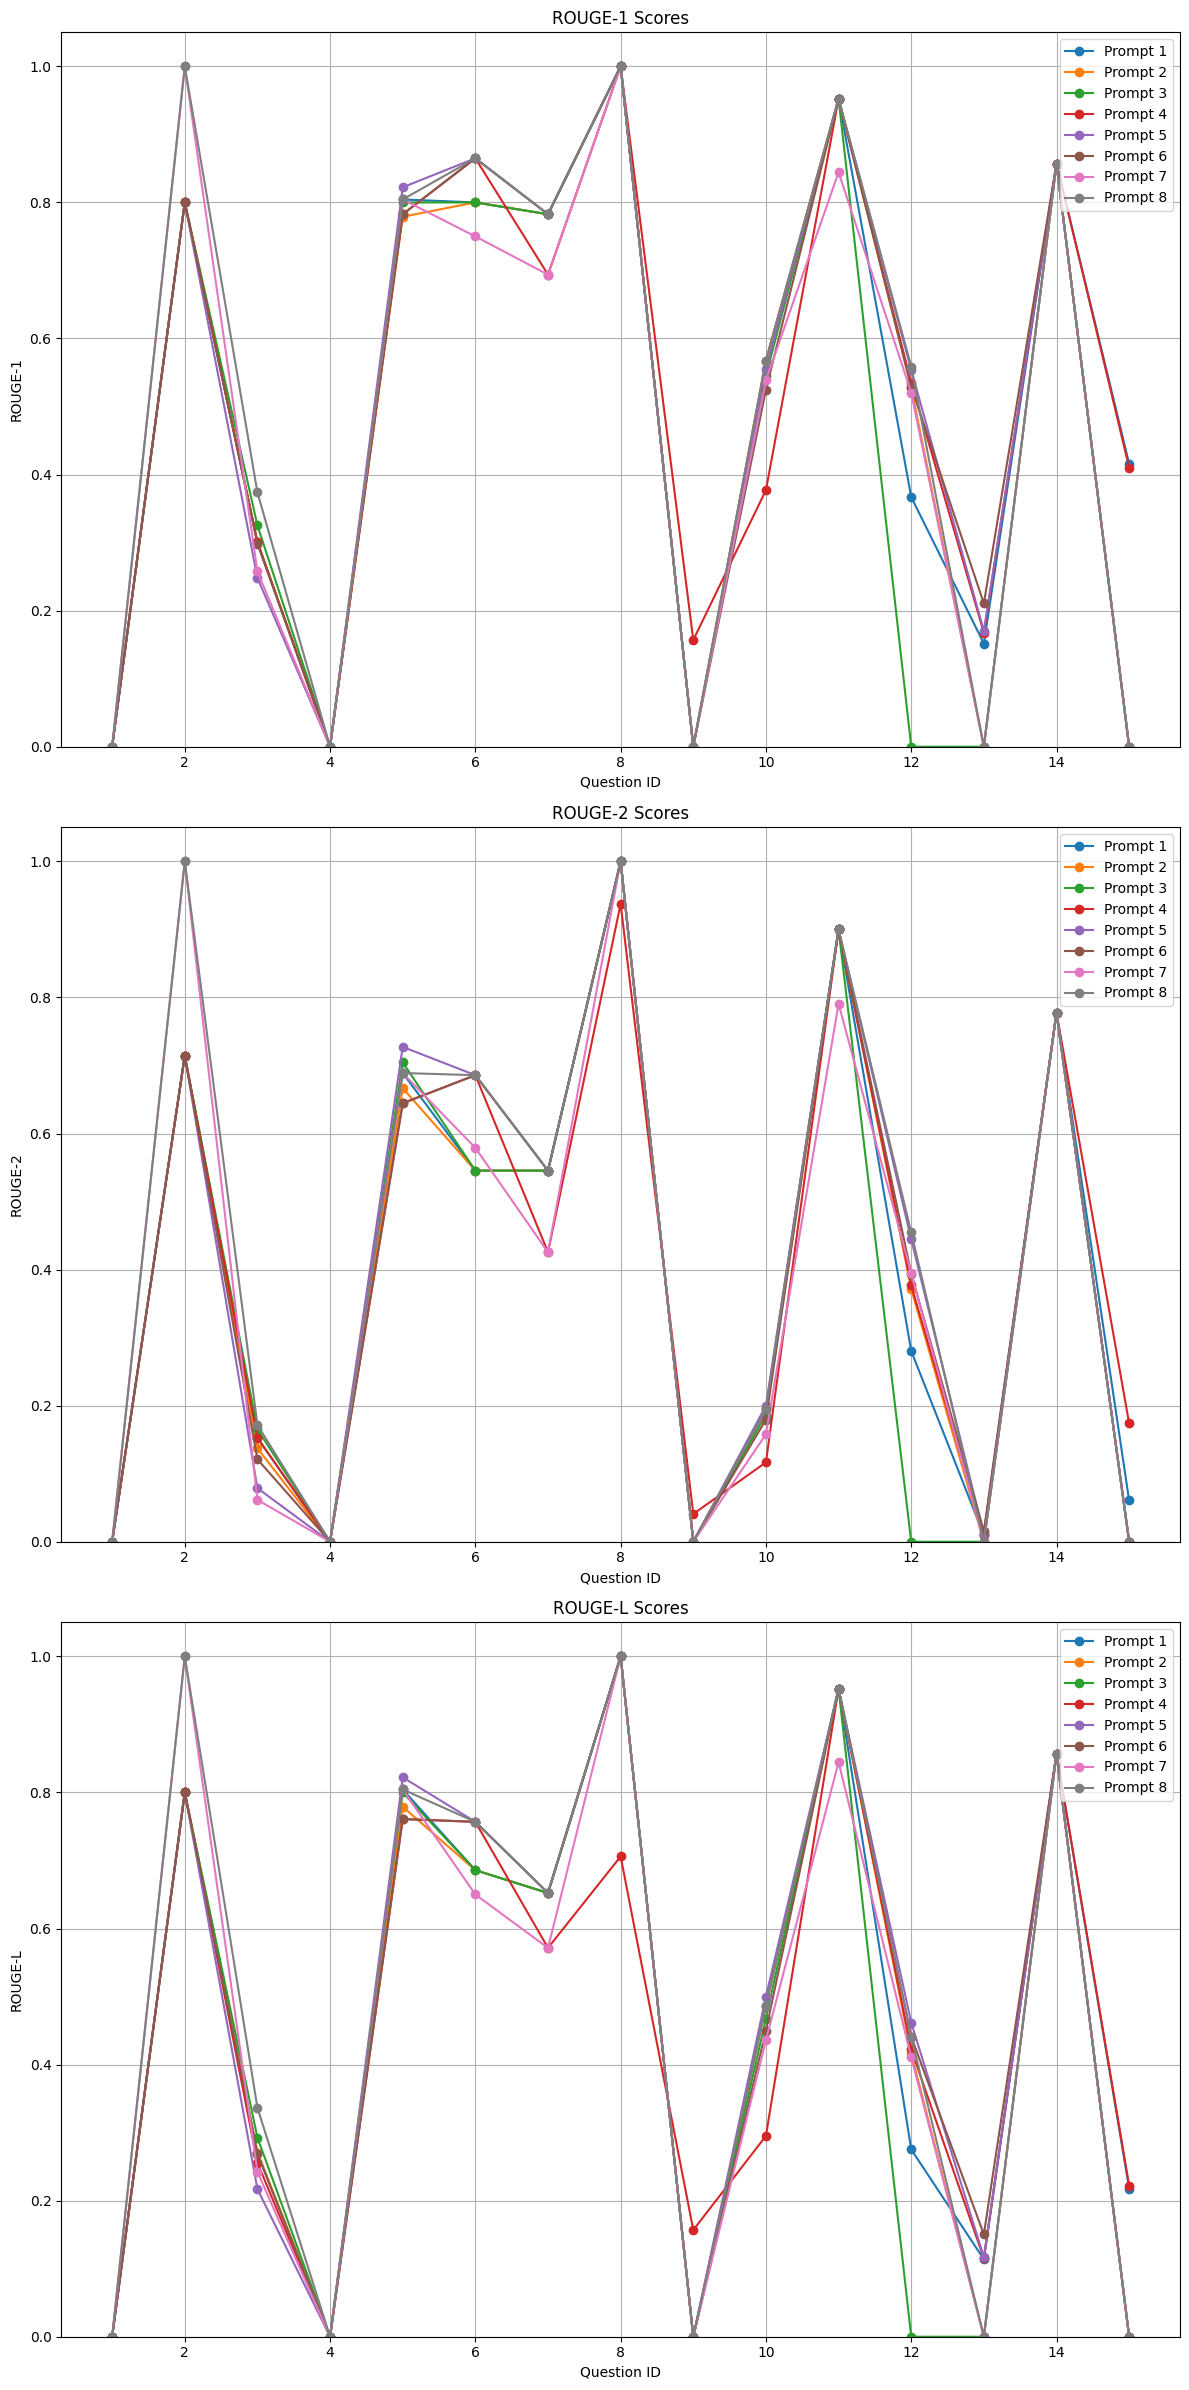

In [ ]:
# Convert summary results to DataFrame
df_summary = pd.DataFrame(evaluation_results_summary)

# Plot 1: Line Graphs for Individual ROUGE Scores
plt.figure(figsize=(12, 24))  # Increased figure height for better spacing between plots

for i, (rouge_type, title) in enumerate(zip(["ROUGE-1", "ROUGE-2", "ROUGE-L"],
                                            ["ROUGE-1 Scores", "ROUGE-2 Scores", "ROUGE-L Scores"])):
    plt.subplot(3, 1, i + 1)  # Change layout to 3 rows, 1 column
    for prompt_name, scores in evaluation_results_detailed.items():
        plt.plot(range(1, len(scores[rouge_type]) + 1), scores[rouge_type], label=prompt_name, marker='o')
    plt.title(title)
    plt.xlabel("Question ID")
    plt.ylabel(rouge_type)
    plt.ylim(0, 1.05)  # Set limits for better visual spacing
    plt.legend(loc="upper right")  # Adjust legend position to avoid overlap
    plt.grid(True)

plt.tight_layout()
plt.savefig("adjusted_individual_rouge_scores.png")
plt.show()

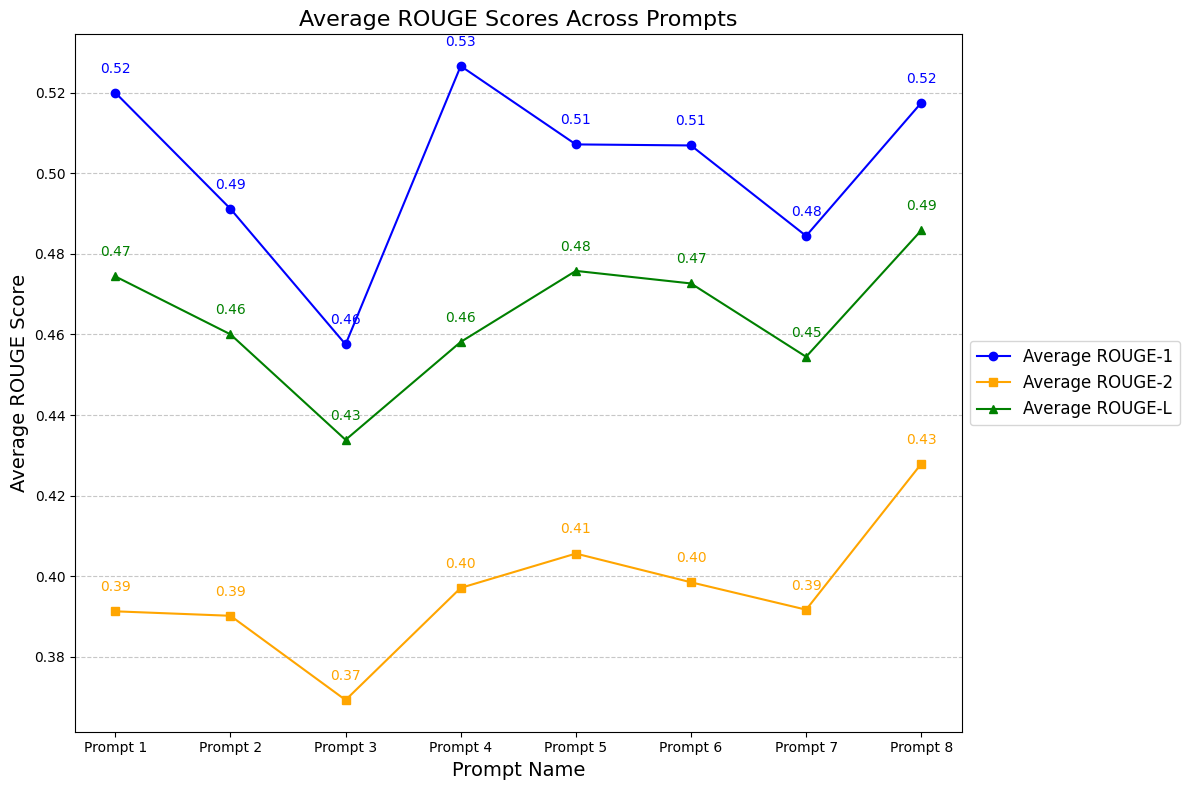

In [ ]:
import matplotlib.pyplot as plt

# Extract prompt names and average ROUGE scores from the summary
prompt_names = [entry["Prompt Name"] for entry in evaluation_results_summary]
average_rouge1 = [entry["Average ROUGE-1"] for entry in evaluation_results_summary]
average_rouge2 = [entry["Average ROUGE-2"] for entry in evaluation_results_summary]
average_rougeL = [entry["Average ROUGE-L"] for entry in evaluation_results_summary]

# Create the line plot
plt.figure(figsize=(12, 8))

# Plot each ROUGE metric
plt.plot(prompt_names, average_rouge1, marker='o', label='Average ROUGE-1', color='blue')
plt.plot(prompt_names, average_rouge2, marker='s', label='Average ROUGE-2', color='orange')
plt.plot(prompt_names, average_rougeL, marker='^', label='Average ROUGE-L', color='green')

# Add values to each point
for i, val in enumerate(average_rouge1):
    plt.text(i, val + 0.005, f"{val:.2f}", ha='center', fontsize=10, color='blue')
for i, val in enumerate(average_rouge2):
    plt.text(i, val + 0.005, f"{val:.2f}", ha='center', fontsize=10, color='orange')
for i, val in enumerate(average_rougeL):
    plt.text(i, val + 0.005, f"{val:.2f}", ha='center', fontsize=10, color='green')

# Add title, labels, and legend
plt.title("Average ROUGE Scores Across Prompts", fontsize=16)
plt.xlabel("Prompt Name", fontsize=14)
plt.ylabel("Average ROUGE Score", fontsize=14)

# Move legend outside the plot
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout and show the plot
plt.tight_layout()
plt.savefig("avg_rouge_scores.png")
plt.show()

## Chunk Size Testing

In [ ]:
# Chunk configurations to test
chunk_configs = [
    {"chunk_size": 700, "chunk_overlap": 70},
    {"chunk_size": 1000, "chunk_overlap": 100},
    {"chunk_size": 5000, "chunk_overlap": 500},
    {"chunk_size": 8000, "chunk_overlap": 800},
    {"chunk_size": 10000, "chunk_overlap": 1000},
    {"chunk_size": 15000, "chunk_overlap": 1500},
    {"chunk_size": 20000, "chunk_overlap": 2000},
]

# Prompts to test
prompts_to_test = [
    {"prompt": prompt1, "name": "Prompt 1"},
    {"prompt": prompt8, "name": "Prompt 8"}
]

# Storage for results
evaluation_results_chunking = []

# Loop through each chunk configuration and prompt
for config in chunk_configs:
    print(f"Testing chunk size {config['chunk_size']} with overlap {config['chunk_overlap']}...\n")

    # Split text into chunks
    text_chunks = split_text_into_chunks(
        raw_text,
        chunk_size=config["chunk_size"],
        chunk_overlap=config["chunk_overlap"]
    )

    # Rebuild FAISS index with new chunks
    faiss_index = create_faiss_index(text_chunks, embedding_model)
    retriever = faiss_index.as_retriever()

    # Test with each prompt
    for prompt in prompts_to_test:
        print("*****************************************************************************************************************")
        print(f"Evaluating {prompt['name']} with Chunk Size {config['chunk_size']} and Overlap {config['chunk_overlap']}...\n")
        evaluation_output = evaluate_rag_with_prompt(
            chat_model=chat_model,
            retriever=retriever,
            ground_truth=ground_truth,
            prompt_template=prompt["prompt"],
            prompt_name=f"{prompt['name']}_Chunk-{config['chunk_size']}_Overlap-{config['chunk_overlap']}"
        )

        # Store results
        avg_scores = evaluation_output["average_scores"]
        results = evaluation_output["results"]

        # Append average results to the summary
        evaluation_results_chunking.append({
            "prompt_name": prompt["name"],
            "chunk_size": config["chunk_size"],
            "chunk_overlap": config["chunk_overlap"],
            "ROUGE-1": avg_scores["avg_rouge1"],
            "ROUGE-2": avg_scores["avg_rouge2"],
            "ROUGE-L": avg_scores["avg_rougeL"],
        })

# Convert results to DataFrame
df_chunking = pd.DataFrame(evaluation_results_chunking)

# Plotting ROUGE scores for Prompt 1 and Prompt 8
for prompt_name in ["Prompt 1", "Prompt 8"]:
    df_filtered = df_chunking[df_chunking["prompt_name"] == prompt_name]

    plt.figure(figsize=(12, 8))
    plt.plot(df_filtered["chunk_size"], df_filtered["ROUGE-1"], marker='o', label="ROUGE-1", color="blue")
    plt.plot(df_filtered["chunk_size"], df_filtered["ROUGE-2"], marker='s', label="ROUGE-2", color="orange")
    plt.plot(df_filtered["chunk_size"], df_filtered["ROUGE-L"], marker='^', label="ROUGE-L", color="green")
    plt.title(f"ROUGE Scores vs Chunk Size for {prompt_name}", fontsize=16)
    plt.xlabel("Chunk Size", fontsize=14)
    plt.ylabel("ROUGE Scores", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

Testing chunk size 700 with overlap 70...

*****************************************************************************************************************
Evaluating Prompt 1 with Chunk Size 700 and Overlap 70...

Individual Results:
Question: How did Meta’s workforce change by the end of 2023?
Ground Truth: By the end of 2023, Meta had 67,317 employees. In 2022, Meta had 87,314 employees, so Meta had a 22.9% decrease in 2023 compared to 2022.
Predicted Answer: Meta's workforce decreased by 22% year-over-year by the end of 2023.
ROUGE-1: 0.37209302325581395, ROUGE-2: 0.1951219512195122, ROUGE-L: 0.23255813953488377

Question: What is the report quarter, and when did it end?
Ground Truth: The reported quarter is the fourth quarter of 2023. The quarter ended on December 31, 2023.
Predicted Answer: The report quarter is the fourth quarter, and it ended on December 31, 2023.
ROUGE-1: 0.7999999999999999, ROUGE-2: 0.7142857142857142, ROUGE-L: 0.7999999999999999

Question: What were the key

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-ysFITxt0H187tQChjiRK3gZH on tokens per min (TPM): Limit 30000, Used 25852, Requested 7305. Please try again in 6.314s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}